In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [94]:
games = pd.read_csv('team_data_v4.csv')
X = games.iloc[:, 3:14]
y = games.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

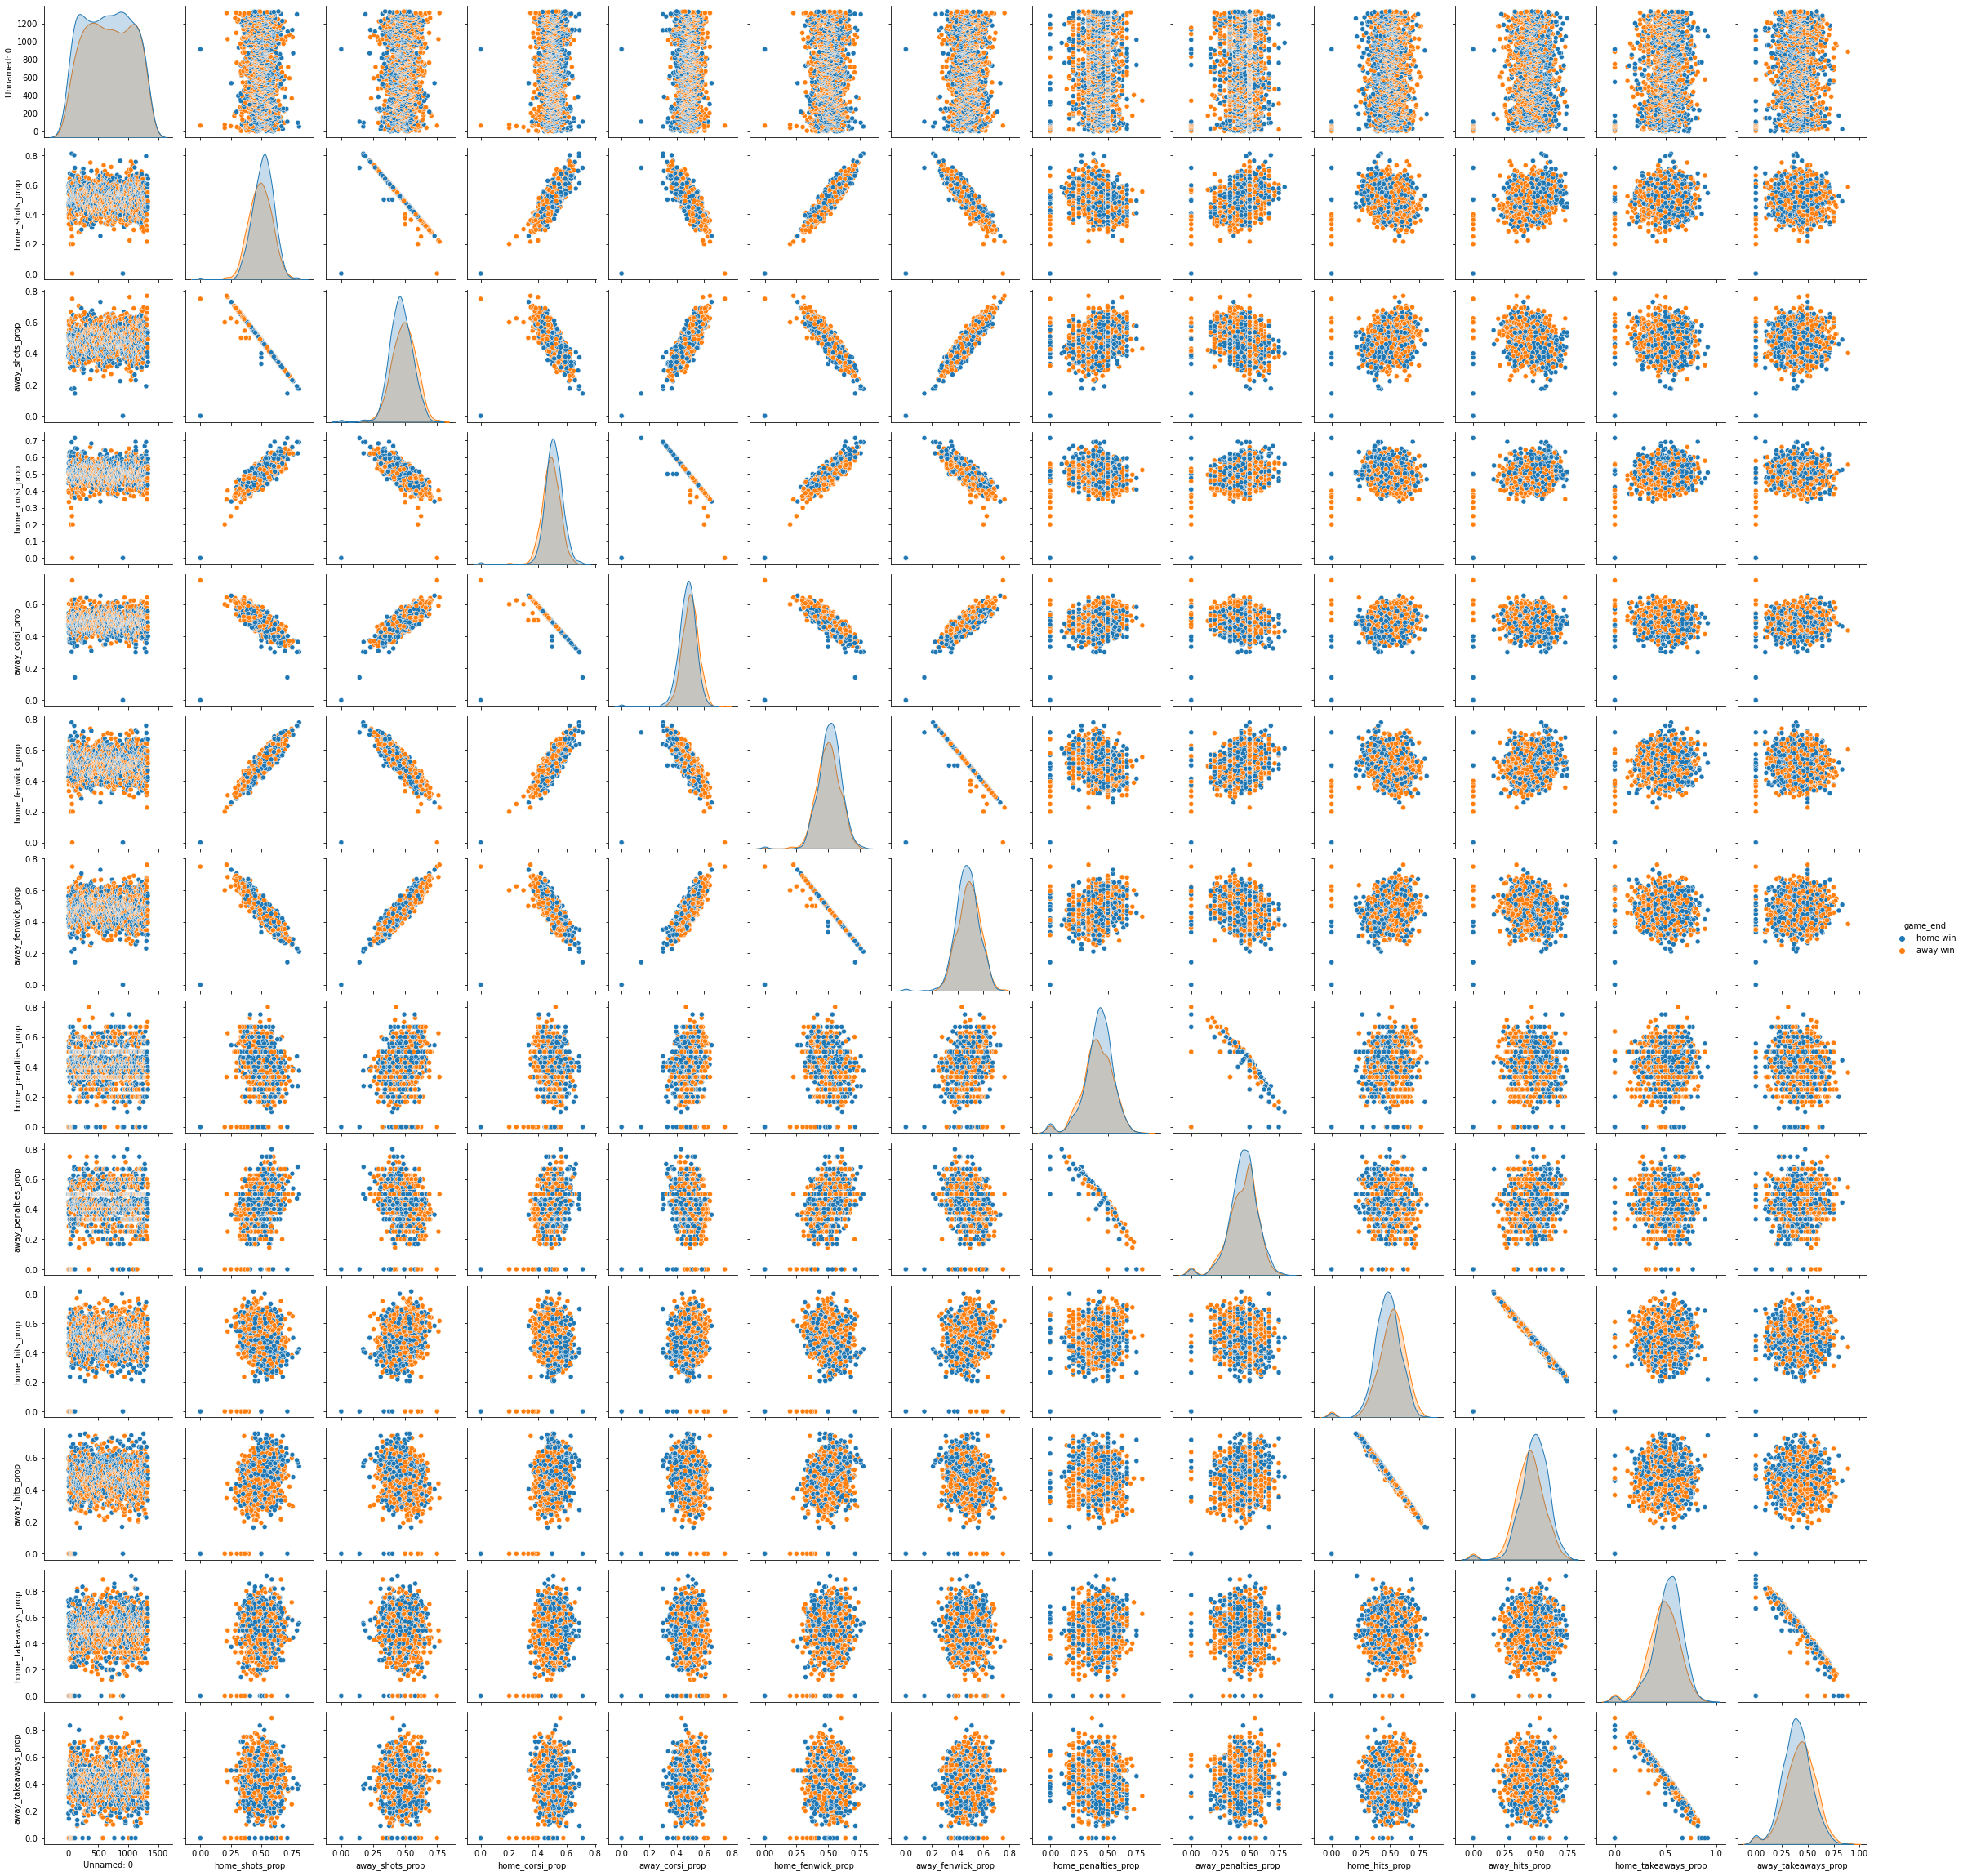

In [14]:
sns.pairplot(games, hue='game_end')

In [103]:
def pick_initial_centroids(df, k):
    return df.sample(k)

def update_centroids(features, centroids):
    dist = cdist(features, centroids)
    closest =  np.argmin(dist, axis=1)
    df = features.copy()
    df['cluster'] = closest
    return df.groupby('cluster').mean()


def kmeans(features, k):
    centroids = pick_initial_centroids(features, k)
    new_centroids = update_centroids(features, centroids)
    
    while not new_centroids.equals(centroids):
        centroids = new_centroids.copy()
        new_centroids = update_centroids(features, centroids)
        
    dist = cdist(features, centroids)
    closest =  np.argmin(dist, axis=1)
    df = features.copy()
    df['cluster'] = closest
    return df, centroids

In [105]:
clustered, centroids = kmeans(X_train, k=20)
clustered

home_shots_prop  away_shots_prop  home_corsi_prop  away_corsi_prop  \
464          0.530303         0.454545         0.513043         0.478261   
1005         0.437500         0.546875         0.500000         0.491071   
748          0.333333         0.650794         0.404959         0.586777   
1108         0.716981         0.264151         0.587629         0.402062   
187          0.419355         0.564516         0.475000         0.516667   
...               ...              ...              ...              ...   
763          0.544118         0.441176         0.550725         0.442029   
835          0.506494         0.480519         0.516393         0.475410   
1216         0.519481         0.467532         0.543860         0.447368   
559          0.530612         0.448980         0.537037         0.453704   
684          0.522388         0.462687         0.533333         0.457143   

      home_fenwick_prop  away_fenwick_prop  home_penalties_prop  \
464            0.526316           0.463158             0.444444   
1005           0.416667           0.571429             0.333333   
748            0.380952           0.607143             0.636364   
1108           0.626667           0.360000             0.333333   
187            0.406593           0.582418             0.428571   
...                 ...                ...                  ...   
763            0.510000           0.480000             0.400000   
835            0.509804           0.480392             0.333333   
1216           0.542553           0.446809             0.444444   
559            0.537500           0.450000             0.428571   
684            0.556818           0.431818             0.285714   

      away_penalties_prop  home_hits_prop  away_hits_prop  \
464              0.444444        0.565789        0.421053   
1005             0.500000        0.562500        0.416667   
748              0.272727        0.609756        0.365854   
1108             0.583333        0.387097        0.580645   
187              0.428571        0.371795        0.615385   
...                   ...             ...             ...   
763              0.400000        0.444444        0.539683   
835              0.500000        0.406250        0.562500   
1216             0.500000        0.309524        0.666667   
559              0.428571        0.384615        0.589744   
684              0.571429        0.500000        0.480000   

      home_takeaways_prop  cluster  
464              0.285714        4  
1005             0.388889       19  
748              0.000000       19  
1108             0.590909       17  
187              0.722222        8  
...                   ...      ...  
763              0.285714        4  
835              0.476190        6  
1216             0.400000        6  
559              0.363636        0  
684              0.428571        2  

[999 rows x 12 columns]

In [76]:
sns.pairplot(clustered, hue='cluster' , palette='deep')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [97]:
def wcss(clustered):
    # Step 1 - find the centroids
    centroids = clustered.groupby('cluster').mean()
    # Step 2 - compute distances to each centroid, but extract, the distance for the assigned cluster
    wcss = cdist(clustered.iloc[:, :11], centroids)[np.arange(len(clustered)), clustered.iloc[:,-1]].sum()
    return wcss

wcss(clustered)

171.77116416991518

Text(0.5, 0, 'K')

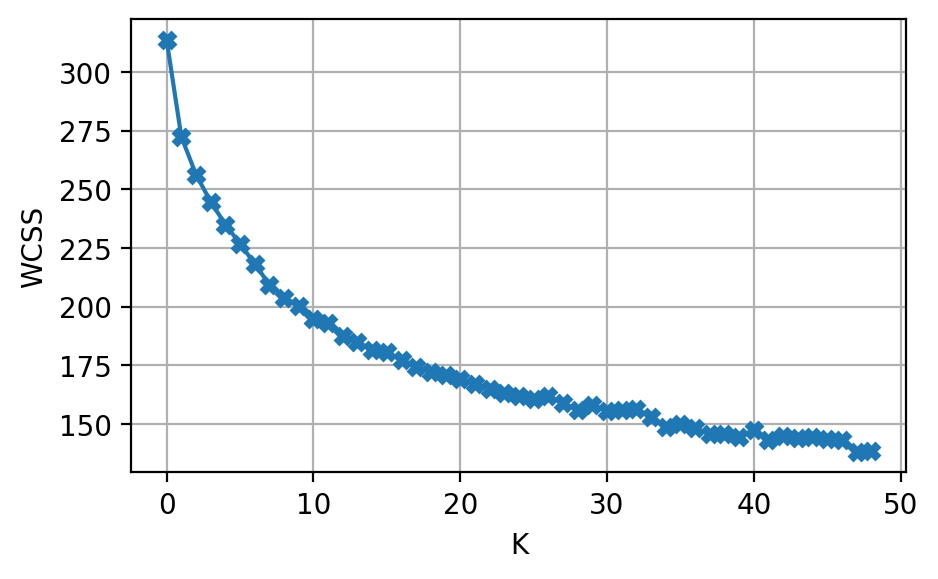

In [98]:
wcss_scores = [wcss(kmeans(X_train, k)) for k in range(1, 50)]

plt.figure(figsize=(5,3), dpi=200)
plt.plot(wcss_scores, marker='X')
plt.grid()
plt.ylabel('WCSS')
plt.xlabel('K')

In [129]:
def classify_cluster(df, k):
    home = len(df[(df['cluster'] == k) & (df['game_end'] == 'home win')])
    away = len(df[(df['cluster'] == k) & (df['game_end'] == 'away win')])
    if home > away:
        return 'home win'
    else:
        return 'away win'

In [130]:
def predict(X_train, y_train, X_test, k):
    clustered, centroids = kmeans(X_train, k=k)
    clustered = clustered.join(y_train)
    dist = cdist(X_test, centroids)
    closest = np.argmin(dist, axis=1)
    df = X_test.copy()
    df['cluster'] = closest
    df['prediction'] = df.apply(lambda x: classify_cluster(clustered, x['cluster']), axis=1)
    return df['prediction']

def metrics(y, ypred):
    unique_classes = set(y) | set(ypred)
    n_classes = len(unique_classes)
    matrix = np.zeros(shape=(n_classes, n_classes), dtype=int)
    actual_prediction = list(zip(y, ypred))
    correct = 0
    for i,j in actual_prediction:
        if i == j:
            correct += 1
    return correct / len(actual_prediction)


Text(0.5, 0, 'K')

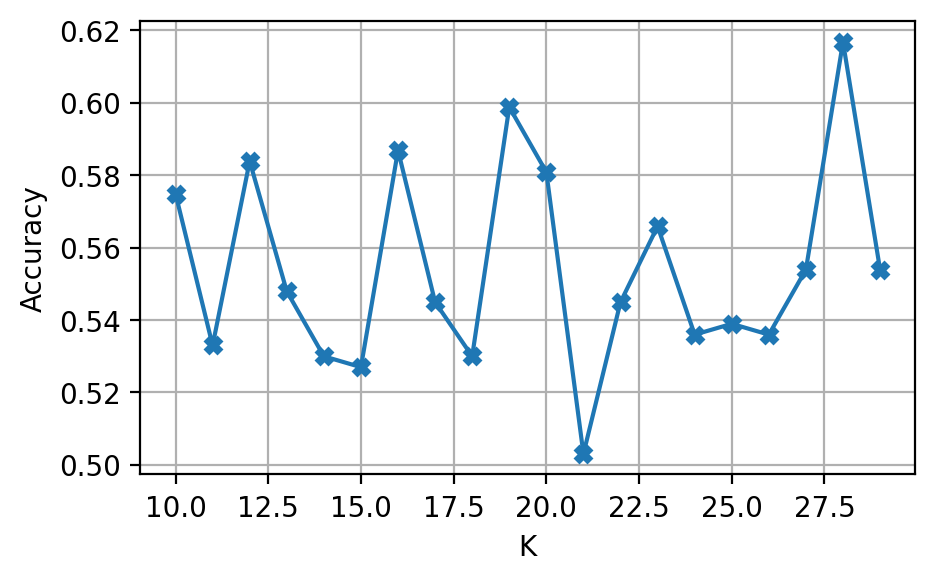

In [156]:
accuracies = [metrics(y_test, predict(X_train, y_train, X_test, k=k)) for k in range(10, 30)]

plt.figure(figsize=(5,3), dpi=200)
plt.plot(list(range(10, 30)), accuracies, marker='X')
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('K')